In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.0'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done


In [2]:
# For loading Packages
import pandas as pd
from pyspark.sql import SparkSession

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# For mathematical calculations
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# To build and evaluate model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import tensorflow as tf

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# To ignore any warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Read CSV with PySpark") \
    .getOrCreate()

# Read CSV file into DataFrame
df = spark.read.csv("updated2.csv", header=True, inferSchema=True)

# Show the DataFrame
df.show()

# Stop the SparkSession
#spark.stop()

+-----------+----------+---------+-------+-------------+----+-----+-----------+---------+------------------+------+------+------------------+---------+--------+---------+-----+----------+-----------+-----------+-------+----------+-----------+---------+
|PassengerId|HomePlanet|CryoSleep|  Cabin|  Destination| Age|  VIP|RoomService|FoodCourt|      ShoppingMall|   Spa|VRDeck|              Name|CabinDeck|CabinNo.|CabinSide|Group|Group_size|  Last_name|Family_size|IsAlone|Luxury_exp|Regular_exp|Total_exp|
+-----------+----------+---------+-------+-------------+----+-----+-----------+---------+------------------+------+------+------------------+---------+--------+---------+-----+----------+-----------+-----------+-------+----------+-----------+---------+
|    0001_01|    Europa|    false|  B/0/P|  TRAPPIST-1e|39.0|false|        0.0|      0.0|               0.0|   0.0|   0.0|   Maham Ofracculy|        B|       0|        P|    1|         1|  Ofracculy|        3.0|   true|       0.0|        0.0

In [5]:
# Print the schema of the DataFrame
df.printSchema()

df.createOrReplaceTempView("data")



root
 |-- PassengerId: string (nullable = true)
 |-- HomePlanet: string (nullable = true)
 |-- CryoSleep: boolean (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- VIP: boolean (nullable = true)
 |-- RoomService: double (nullable = true)
 |-- FoodCourt: double (nullable = true)
 |-- ShoppingMall: double (nullable = true)
 |-- Spa: double (nullable = true)
 |-- VRDeck: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- CabinDeck: string (nullable = true)
 |-- CabinNo.: integer (nullable = true)
 |-- CabinSide: string (nullable = true)
 |-- Group: integer (nullable = true)
 |-- Group_size: integer (nullable = true)
 |-- Last_name: string (nullable = true)
 |-- Family_size: double (nullable = true)
 |-- IsAlone: boolean (nullable = true)
 |-- Luxury_exp: double (nullable = true)
 |-- Regular_exp: double (nullable = true)
 |-- Total_exp: double (nullable = true)



In [8]:
# Convert PySpark DataFrame to Pandas DataFrame
full_data = df.toPandas()
spark.stop()

In [9]:
#Read the test and train data after processing null values and feature engineering

full_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Group,Group_size,Last_name,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P,1,1,Ofracculy,3.0,True,0.0,0.0,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S,2,1,Vines,4.0,True,702.0,34.0,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S,3,2,Susent,7.0,False,6807.0,3576.0,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S,3,2,Susent,7.0,False,3522.0,1654.0,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S,4,1,Santantines,9.0,True,870.0,221.0,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,G,1496,S,9266,2,Peter,10.0,False,0.0,0.0,0.0
12966,9269_01,Earth,False,G/160/P,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,F,82,S,9269,1,Scheron,6.0,True,154.0,864.0,1018.0
12967,9271_01,Mars,True,D/296/P,55 Cancri e,28.771969,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,D,296,P,9271,1,Pore,4.0,True,0.0,0.0,0.0
12968,9273_01,Europa,False,D/297/P,TRAPPIST-1e,28.771969,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,D,297,P,9273,1,Conale,7.0,True,523.0,2680.0,3203.0


In [10]:
#Check if there are no more missing values
full_data.isnull().sum().sort_values(ascending=False)

PassengerId     0
HomePlanet      0
Regular_exp     0
Luxury_exp      0
IsAlone         0
Family_size     0
Last_name       0
Group_size      0
Group           0
CabinSide       0
CabinNo.        0
CabinDeck       0
Name            0
VRDeck          0
Spa             0
ShoppingMall    0
FoodCourt       0
RoomService     0
VIP             0
Age             0
Destination     0
Cabin           0
CryoSleep       0
Total_exp       0
dtype: int64

In [11]:
#Original train data from the challenge
train = pd.read_csv('train.csv')
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [12]:
#Add the "Transported" value to the data
full_tran = pd.merge(full_data, train[['PassengerId','Transported']], on='PassengerId', how='left')
full_tran


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Group,Group_size,Last_name,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P,1,1,Ofracculy,3.0,True,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S,2,1,Vines,4.0,True,702.0,34.0,736.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S,3,2,Susent,7.0,False,6807.0,3576.0,10383.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S,3,2,Susent,7.0,False,3522.0,1654.0,5176.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S,4,1,Santantines,9.0,True,870.0,221.0,1091.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,G,1496,S,9266,2,Peter,10.0,False,0.0,0.0,0.0,NaN
12966,9269_01,Earth,False,G/160/P,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,F,82,S,9269,1,Scheron,6.0,True,154.0,864.0,1018.0,NaN
12967,9271_01,Mars,True,D/296/P,55 Cancri e,28.771969,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,D,296,P,9271,1,Pore,4.0,True,0.0,0.0,0.0,NaN
12968,9273_01,Europa,False,D/297/P,TRAPPIST-1e,28.771969,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,D,297,P,9273,1,Conale,7.0,True,523.0,2680.0,3203.0,NaN


In [13]:
#Drop the columns that are not necessary for the analysis
full_tran = full_tran.drop(columns = ['PassengerId','Cabin','Name','CabinNo.','Group','Last_name'])

In [14]:
#Divide the data of train and test
train_full = full_tran.loc[full_tran['Transported'].notnull()]
test_full = full_tran.loc[full_tran['Transported'].isnull()]

In [15]:
#Check that everything is ok
print(train_full.shape)
print(test_full.shape)

(8693, 19)
(4277, 19)


In [16]:
#Check the train data
train_full.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Group_size,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,P,1,3.0,True,0.0,0.0,0.0,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,S,1,4.0,True,702.0,34.0,736.0,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,S,2,7.0,False,6807.0,3576.0,10383.0,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,S,2,7.0,False,3522.0,1654.0,5176.0,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,S,1,9.0,True,870.0,221.0,1091.0,True


In [17]:
#Prepare the X for the Ml model dropping the Y column
X = train_full.drop(columns='Transported')

In [18]:
#Define the numerical and the categorical columns in the X

numerical_columns = X.select_dtypes(include=['int','float64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns
print(numerical_columns)
print(categorical_columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Group_size', 'Family_size', 'Luxury_exp', 'Regular_exp', 'Total_exp'],
      dtype='object')
Index(['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide'], dtype='object')


In [19]:
#Convert the categorical columns in dummies for the X
X_encoded = pd.get_dummies(X, columns=categorical_columns)


In [20]:
#Check the X encoded structure
X_encoded

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_size,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,1,3.0,True,0.0,0.0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,1,4.0,True,702.0,34.0,736.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,2,7.0,False,6807.0,3576.0,10383.0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,2,7.0,False,3522.0,1654.0,5176.0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,1,9.0,True,870.0,221.0,1091.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,1,3.0,True,1717.0,6819.0,8536.0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
8689,True,18.0,False,0.0,0.0,0.0,0.0,0.0,1,5.0,True,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
8690,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,1,8.0,True,1.0,1872.0,1873.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
8691,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,2,7.0,False,3588.0,1049.0,4637.0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1


In [21]:
#Prepare the Y for the Ml model and converting it to 0 and 1

y = train_full['Transported']
y = y.astype(int)

In [22]:
#Create the RFC baseline model and fit it to the X and Y data
baseline_model = RandomForestClassifier(random_state = 1)
baseline_model.fit(X_encoded, y)

RandomForestClassifier(random_state=1)

In [23]:
# store accuracy of baseline model prediction in results
result = cross_val_score(baseline_model, X_encoded, y, cv = 5, scoring = "accuracy")

# print mean and standard deviation of baseline model
print(np.mean(result))
print(np.std(result))

0.7844255954409469
0.006043248256230623


In [ ]:
#test for better hyperparameters usuing RandomizedSearchCV

paramgrid = {'bootstrap': [ False],
             'criterion': ['log_loss'],
             'max_depth': list(range(5, 20, 1)),
             'n_estimators': [1000,900,1100],
             'min_samples_split': [5,10,20,30,50,100],
             'max_features': ['auto'],

             }
random_search = RandomizedSearchCV(RandomForestClassifier(random_state = 1), paramgrid, n_iter=100, n_jobs=-1)

# fit the grid search model
random_search.fit(X_encoded, y)

# Estimating the optimized value
random_search.best_estimator_

RandomForestClassifier(bootstrap=False, criterion='log_loss', max_depth=9,
                       max_features='auto', min_samples_split=5,
                       n_estimators=1000, random_state=1)

In [ ]:
random_search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'max_features': 'auto',
 'max_depth': 9,
 'criterion': 'log_loss',
 'bootstrap': False}

In [24]:
best_model = RandomForestClassifier(criterion= 'gini', bootstrap = False, max_depth=9, max_features='auto',
                       min_samples_split=3, n_estimators=1000, random_state=1)
best_model.fit(X_encoded, y)

RandomForestClassifier(bootstrap=False, max_depth=9, max_features='auto',
                       min_samples_split=3, n_estimators=1000, random_state=1)

In [27]:
# store accuracy of baseline model prediction in results
result = cross_val_score(best_model, X_encoded, y, cv = 5, scoring = "accuracy")

# print mean and standard deviation of baseline model
print(np.mean(result))
print(np.std(result))

0.8038678102238566
0.010939062028008985


In [ ]:
#test better hyperparameters
paramgrid = {'bootstrap': [True],
             'max_depth': list(range(6, 15, 1)),
             'n_estimators': list(range(500, 1200, 100)),
             'min_samples_split': [10,20,30],
             'min_samples_leaf': [10,20],
             'max_features': ['auto'],
             }
grid_search = GridSearchCV(RandomForestClassifier(random_state = 1), paramgrid, n_jobs=-1, cv=3, verbose=1)

# fit the grid search model
grid_search.fit(X_encoded, y)

# Estimating the optimized value
grid_search.best_estimator_

Fitting 3 folds for each of 378 candidates, totalling 1134 fits


RandomForestClassifier(max_depth=14, max_features='auto', min_samples_leaf=10,
                       min_samples_split=10, n_estimators=600, random_state=1)

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 14,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 600}

In [ ]:
improved_model1 = RandomForestClassifier(bootstrap = False, criterion='log_loss' , max_depth=10, max_features='auto',
                       min_samples_split=30, n_estimators=1000, random_state=1)
improved_model1.fit(X_encoded, y)

RandomForestClassifier(bootstrap=False, criterion='log_loss', max_depth=10,
                       max_features='auto', min_samples_split=30,
                       n_estimators=1000, random_state=1)

In [ ]:
# store accuracy of baseline model prediction in results
result = cross_val_score(improved_model1, X_encoded, y, cv = 5, scoring = "accuracy")

# print mean and standard deviation of baseline model
print(np.mean(result))
print(np.std(result))

0.8035229828658323
0.012898087471511522


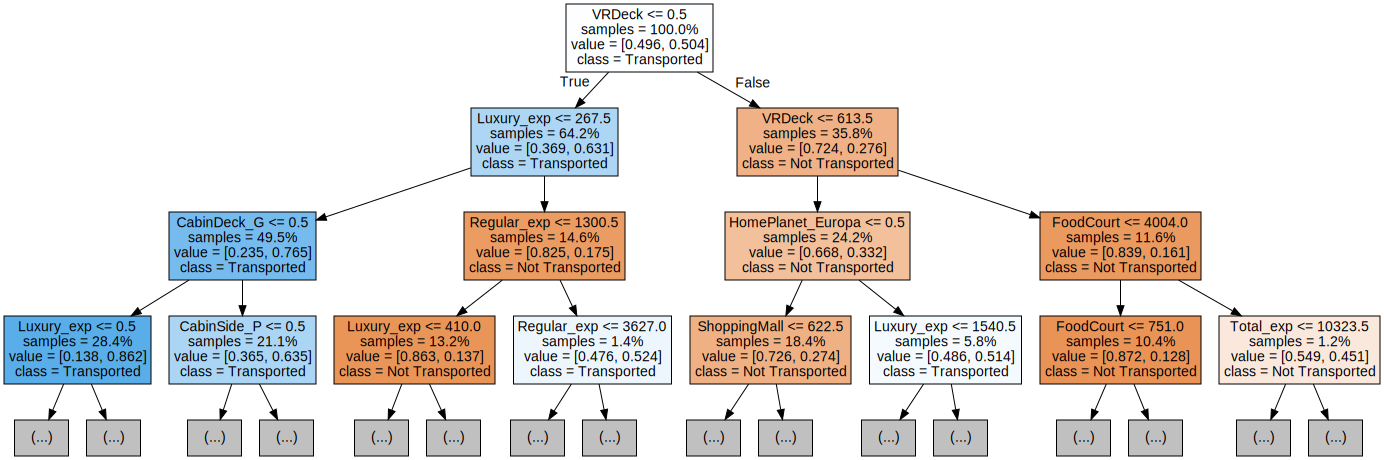

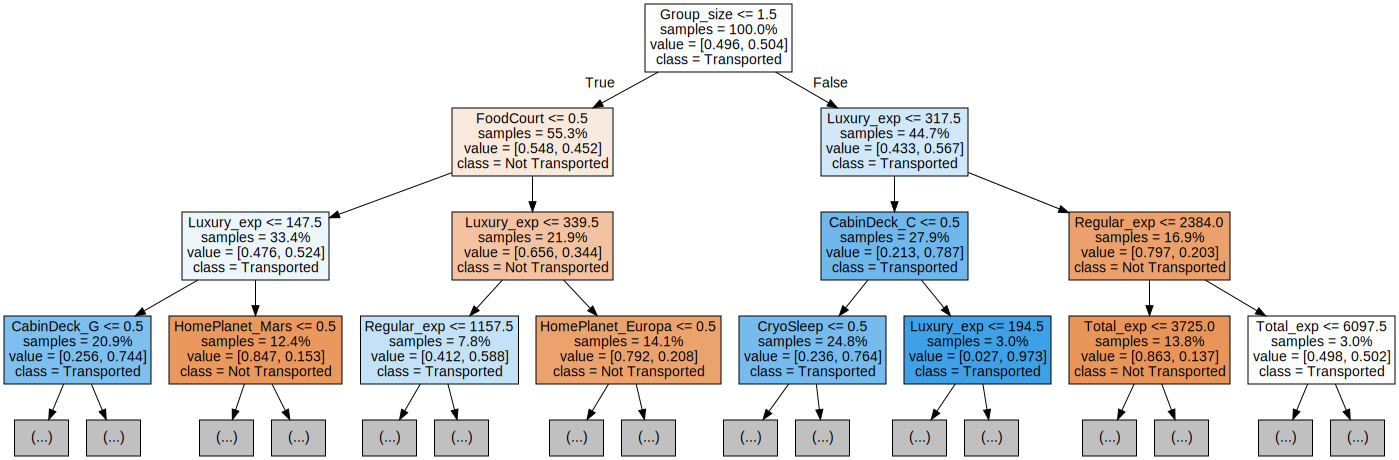

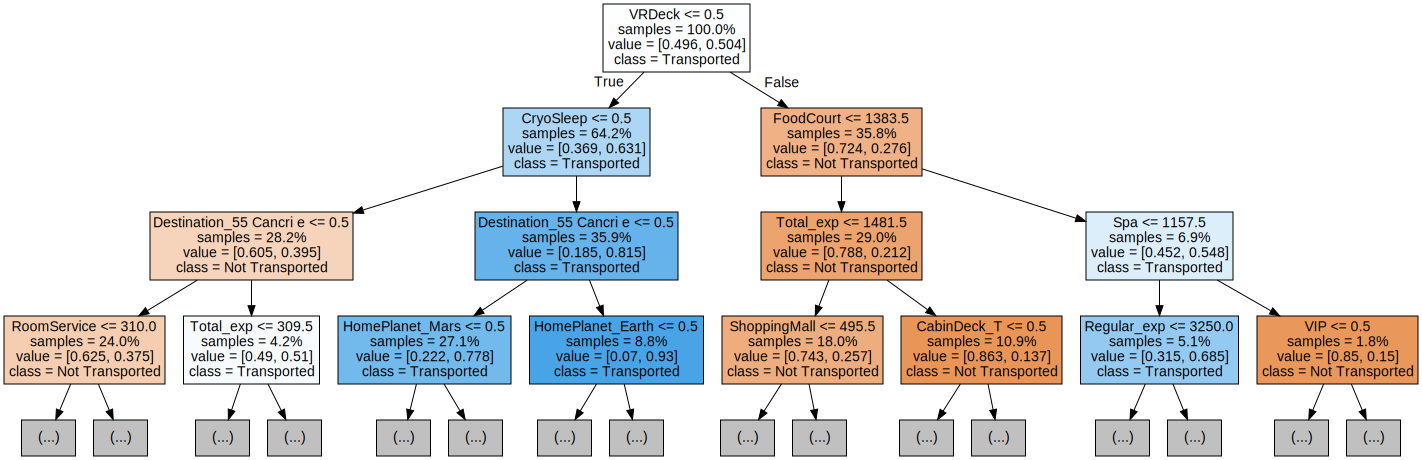

In [26]:
# Export the first three decision trees from the best random forest model

for i in range(3):
    tree = best_model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_encoded.columns,
                               filled=True,
                               max_depth=3,
                               impurity=False,
                               proportion=True,
                               class_names = ('Not Transported', 'Transported'))
    graph = graphviz.Source(dot_data)
    display(graph)
    #graph.render(filename=f'tree_diagram{i}')

## Test data predictions

In [30]:
test_full.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Group_size,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp,Transported
8693,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,S,1,8.0,True,0.0,0.0,0.0,NaN
8694,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,S,1,4.0,True,2823.0,9.0,2832.0,NaN
8695,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,S,1,6.0,True,0.0,0.0,0.0,NaN
8696,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,S,1,2.0,True,766.0,6652.0,7418.0,NaN
8697,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,S,1,5.0,True,10.0,635.0,645.0,NaN


In [31]:
X_test = test_full.drop(columns='Transported')
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns)


In [32]:

X_test_encoded

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_size,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
8693,True,27.000000,False,0.0,0.0,0.0,0.0,0.0,1,8.0,True,0.0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
8694,False,19.000000,False,0.0,9.0,0.0,2823.0,0.0,1,4.0,True,2823.0,9.0,2832.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
8695,True,31.000000,False,0.0,0.0,0.0,0.0,0.0,1,6.0,True,0.0,0.0,0.0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1
8696,False,38.000000,False,0.0,6652.0,0.0,181.0,585.0,1,2.0,True,766.0,6652.0,7418.0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1
8697,False,20.000000,False,10.0,0.0,635.0,0.0,0.0,1,5.0,True,10.0,635.0,645.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,True,34.000000,False,0.0,0.0,0.0,0.0,0.0,2,10.0,False,0.0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
12966,False,42.000000,False,0.0,847.0,17.0,10.0,144.0,1,6.0,True,154.0,864.0,1018.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
12967,True,28.771969,False,0.0,0.0,0.0,0.0,0.0,1,4.0,True,0.0,0.0,0.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0
12968,False,28.771969,False,0.0,2680.0,0.0,0.0,523.0,1,7.0,True,523.0,2680.0,3203.0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0


In [34]:
prediction = best_model.predict(X_test_encoded)

In [35]:
prediction_df = pd.DataFrame(np.array(prediction).reshape(-1,1))
prediction_df = prediction_df.rename(columns={0: "Transported"})
prediction_df

,Transported
0,1
1,0
2,1
3,1
4,1
...,...
4272,1
4273,1
4274,1
4275,1


In [36]:
test = pd.read_csv('test.csv')
test_id = test['PassengerId']
test_id=pd.DataFrame(test_id)
test_id

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01
...,...
4272,9266_02
4273,9269_01
4274,9271_01
4275,9273_01


In [37]:
predictions = test_id.join(prediction_df)
predictions

,PassengerId,Transported
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1
...,...,...
4272,9266_02,1
4273,9269_01,1
4274,9271_01,1
4275,9273_01,1


In [38]:
predictions['Transported'] = predictions['Transported'].map({1: True, 0: False})
predictions

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [39]:
predictions.to_csv('predictions6.csv', index=False)

# Neural Network Attemp

In [ ]:
numerical_columns = X.select_dtypes(include=['int','float64']).columns
categorical_columns = X.select_dtypes(include=['object','boolean']).columns

print(numerical_columns)
print(categorical_columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Group_size', 'Family_size', 'Luxury_exp', 'Regular_exp', 'Total_exp'],
      dtype='object')
Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck',
       'CabinSide', 'IsAlone'],
      dtype='object')


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('numeric', StandardScaler(), numerical_columns)
        ])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.704388,-0.332581,-0.283561,-0.277006,-0.279983,-0.261588,-0.027875,-1.229493,-0.449196,-0.359901,-0.510400
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.983617,-0.007623,0.267259,-0.277006,-0.279983,-0.261588,-0.655186,1.390930,-0.449196,0.157436,-0.197177
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.342720,-0.304661,0.135757,-0.277006,-0.256606,-0.261588,-0.655186,0.517456,-0.424820,0.033928,-0.256083
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.901178,-0.332581,-0.283561,-0.178323,-0.279983,1.437905,-0.027875,-0.064861,0.614151,-0.324946,0.203170
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.552142,0.206713,-0.109259,-0.277006,-0.279983,-0.135186,-0.655186,1.390930,-0.171307,-0.196194,-0.230334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6949,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.634581,0.969366,-0.283561,0.739426,-0.279983,-0.261588,-0.655186,0.226298,0.030745,0.000138,0.020104
6950,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.704388,-0.332581,-0.121665,0.007408,1.366269,1.294189,-0.027875,0.517456,1.516073,-0.207846,0.861360
6951,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.342720,-0.007623,-0.263712,-0.263848,-0.279983,-0.261588,-0.655186,0.808614,-0.449196,-0.336597,-0.496291
6952,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.262845,-0.332581,-0.283561,-0.277006,-0.279983,-0.261588,-0.027875,0.226298,-0.449196,-0.359901,-0.510400


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(units=60, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=40, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                2040      
                                                                 
 dense_1 (Dense)             (None, 50)                3050      
                                                                 
 dense_2 (Dense)             (None, 40)                2040      
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 7171 (28.01 KB)
Trainable params: 7171 (28.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=100, verbose=True)

Epoch 1/100
218/218 [==============================] - 5s 5ms/step - loss: 0.4786 - accuracy: 0.7676
Epoch 2/100
218/218 [==============================] - 1s 5ms/step - loss: 0.4228 - accuracy: 0.7918
Epoch 3/100
218/218 [==============================] - 1s 4ms/step - loss: 0.4099 - accuracy: 0.7982
Epoch 4/100
218/218 [==============================] - 1s 3ms/step - loss: 0.4044 - accuracy: 0.8041
Epoch 5/100
218/218 [==============================] - 1s 3ms/step - loss: 0.3979 - accuracy: 0.8028
Epoch 6/100
218/218 [==============================] - 1s 3ms/step - loss: 0.3966 - accuracy: 0.8034
Epoch 7/100
218/218 [==============================] - 0s 2ms/step - loss: 0.3904 - accuracy: 0.8102
Epoch 8/100
218/218 [==============================] - 0s 2ms/step - loss: 0.3882 - accuracy: 0.8105
Epoch 9/100
218/218 [==============================] - 0s 2ms/step - loss: 0.3851 - accuracy: 0.8125
Epoch 10/100
218/218 [==============================] - 0s 2ms/step - loss: 0.3816 - accura

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

55/55 [==============================] - 1s 5ms/step - loss: 0.9002 - accuracy: 0.7683
Test accuracy: 0.7682576179504395, Test loss: 0.9002386927604675


In [ ]:
X_pred = test_full.drop(columns="Transported")
X_pred

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Group_size,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp
8693,Earth,True,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0,G,S,1,8.0,True,0.0,0.0,0.0
8694,Earth,False,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0,F,S,1,4.0,True,2823.0,9.0,2832.0
8695,Europa,True,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0,C,S,1,6.0,True,0.0,0.0,0.0
8696,Europa,False,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0,C,S,1,2.0,True,766.0,6652.0,7418.0
8697,Earth,False,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0,F,S,1,5.0,True,10.0,635.0,645.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,True,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,G,S,2,10.0,False,0.0,0.0,0.0
12966,Earth,False,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,F,S,1,6.0,True,154.0,864.0,1018.0
12967,Mars,True,55 Cancri e,28.771969,False,0.0,0.0,0.0,0.0,0.0,D,P,1,4.0,True,0.0,0.0,0.0
12968,Europa,False,TRAPPIST-1e,28.771969,False,0.0,2680.0,0.0,0.0,523.0,D,P,1,7.0,True,523.0,2680.0,3203.0


In [ ]:
X_pred = preprocessor.transform(X_pred)

In [ ]:
pd.DataFrame(X_pred)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.133299,-0.332581,-0.283561,-0.277006,-0.279983,-0.261588,-0.655186,0.226298,-0.449196,-0.359901,-0.510400
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.691756,-0.332581,-0.277979,-0.277006,2.258175,-0.261588,-0.655186,-0.938335,1.080008,-0.354657,0.488527
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.145930,-0.332581,-0.283561,-0.277006,-0.279983,-0.261588,-0.655186,-0.356019,-0.449196,-0.359901,-0.510400
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.634581,-0.332581,3.842629,-0.277006,-0.117246,0.244884,-0.655186,-1.520651,-0.034258,3.515466,2.106139
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.621949,-0.317886,-0.283561,0.767387,-0.279983,-0.261588,-0.655186,-0.647177,-0.443779,0.010042,-0.282890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.355352,-0.332581,-0.283561,-0.277006,-0.279983,-0.261588,-0.027875,0.808614,-0.449196,-0.359901,-0.510400
4273,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.913809,-0.332581,0.241827,-0.249046,-0.270992,-0.136918,-0.655186,-0.356019,-0.365775,0.143454,-0.151322
4274,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.009603,-0.332581,-0.283561,-0.277006,-0.279983,-0.261588,-0.655186,-0.938335,-0.449196,-0.359901,-0.510400
4275,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.009603,-0.332581,1.378824,-0.277006,-0.279983,0.191206,-0.655186,-0.064861,-0.165890,1.201431,0.619389


In [ ]:
predictions = (model.predict(X_pred)[:,0]>0.5).astype(bool)

134/134 [==============================] - 0s 2ms/step


In [ ]:
pred_nn=pd.DataFrame(predictions)
pred_nn

,0
0,True
1,False
2,True
3,True
4,True
...,...
4272,True
4273,False
4274,True
4275,True


In [ ]:
pred_nn.to_csv('predictions_nn.csv')